## Null Hypothesis (NH)

- asking yes or no questions (nongaussian, mean nonzero, correlation, nonlinearity in correlation, chaos)
- aim is to disprove the opposite. This opposite is the Null Hypothesis
- accept and reject the hypothesis, by showing, that the data are unlike/like results from the hypothesis
- for that discriminating statistics $T$ is calculated
- rejecting the null hypothesis means, that if it were true it is unlikely this value would be observed
- 
|             | $H_0$ |  $H_1$ |
| ----------- | ----------- | ----------- |
| Result $H_0$      | correct       | Typ II error ($\beta$ error) |
| Result $H_1$    | Type I error ($\alpha$ error)        | correct |

- *size* $\alpha$ corresponds to acceptance rate normally set to $p=0.05$
-  $1-\beta$ is the *power* of the test and influenced by underlying process and $n$


## Monte Carlo



In [9]:
# import statsmodels.tsa as tsa
from pytisean import tiseano, tiseanio
# from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
# import subprocess


%matplotlib inline

# def autocorrelation(x): #todo flatten with mean
#     result = np.correlate(x,x,mode="full")
#     return result[result.size//2:result.size//2+30]

def autocorrelation(x): 
    result, msg = tiseanio('/home/luca/bin/autocor', data=x, silent=True)
    return result[:,1]

def powerspektrum(x):
    result, msg = tiseanio('/home/luca/bin/spectrum', data=x, silent=True)
    return result[:,0], result[:,1]





# fig1, ax1 = plt.subplots(1, 1)
# ax1.scatter(henon[:, 0], henon[:, 1], color='k', s=0.1)
# ax1.set_title('The Henon map')
# ax1.set_xlabel(r'$x$', fontsize=16)
# ax1.set_ylabel(r'$y$', fontsize=16)
# plt.show()

Null Hypothesis 
- simple vs. composite
  
Chaos vs. Noise

- **cypical realizations:** fit a model the data and vary the noise
- **constraind realiszation:** create surrogates with Monte Carlo methods. Constrained to have same Fourier spectrum for example


In [10]:
# # creating an AR2 Timeseries
parameter = np.array([1,0.33,0.5,1])
# ma = np.array([1])


# ar2_data = ArmaProcess(ar2,ma).generate_sample(nsample=9)
ar2_data, msg = tiseanio('/home/luca/bin/ar-run', '-l10', '-p2', data=[1,0.33,0.5,1]
, silent=True)

# ar2_data, msg = tiseano('/home/luca/bin/ar-run', '-l1000', '-p2', '/home/luca/Documents/Repositories/Surrogates/ar3.txt'
# , silent=False)

# print(ar2_data)
# plt.title("Ar(2) generated time series")
# plt.plot(ar2_data)
# plt.show()

# autocorrelation(ar2_data)

# autcorr_ar2 = autocorrelation(ar2_data)
# plt.title("autocorrelation")
# plt.plot(autcorr_ar2)
# plt.show()

def plot_surrogates(time_series, surrogate_method):
    time_series_surrogate = surrogate_method(time_series)
    fig, axs = plt.subplots(4, )
    fig.set_size_inches(5,10)
    mean = np.mean(time_series)
    std = np.std(time_series)
    mean_surrogate = np.mean(time_series_surrogate)
    std_surrogate = np.std(time_series_surrogate)
    axs[0].set_title("Timeseries")
    axs[0].plot(time_series, label=f"Original: mean={mean:.2f}, std={std:.2f}")
    axs[0].plot(time_series_surrogate, label=f"Surrogate: mean={mean_surrogate:.2f}, std={std_surrogate:.2f}")
    axs[0].set_xlabel("time steps")
    axs[0].set_ylabel("value")
    axs[1].set_title("Autocorrelation")
    axs[1].plot(autocorrelation(time_series))
    axs[1].plot(autocorrelation(time_series_surrogate))
    axs[2].set_title("Power Spectrum")
    f, Pxx = powerspektrum(time_series) # calculate power spectrum
    axs[2].plot(f, Pxx)
    f_s, Pxx_s = powerspektrum(time_series_surrogate)
    axs[2].plot(f_s, Pxx_s)
    axs[2].set_xlabel("frequencys")
    axs[2].set_ylabel("power")
    axs[3].hist(time_series)
    axs[3].hist(time_series_surrogate)
    axs[3].set_xlabel("values")
    axs[3].set_ylabel("occurance")
    fig.legend()
    fig.tight_layout()
    plt.plot()
    return
    





Random Shuffle Surrogates (RS)

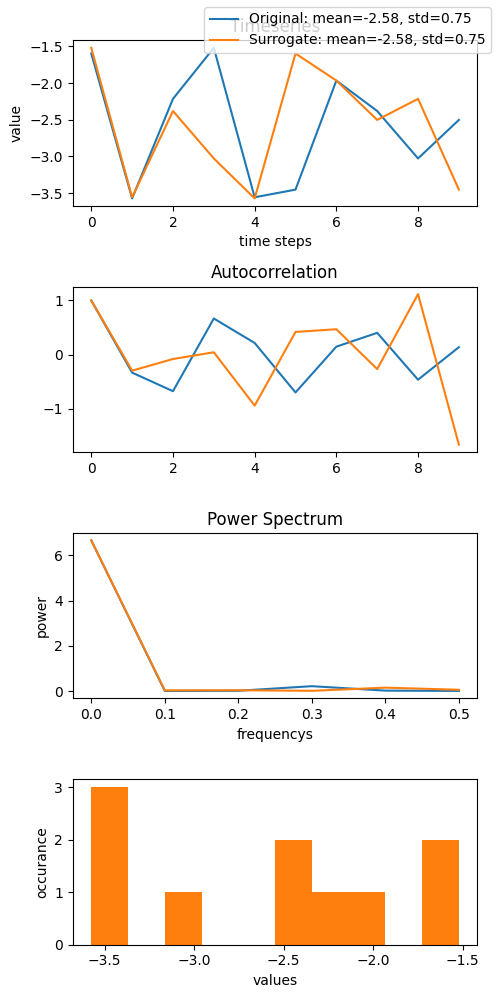

In [11]:
def RS(timeseries):
    """
        shuffles the values of the time series
    """
    RS_surrogate = np.copy(timeseries)
    np.random.shuffle(RS_surrogate)
    return RS_surrogate

plot_surrogates(ar2_data, RS)


### FT

Null Hypothesis: data come from linear gaussian prozess

- FFT
- random phases $\phi$ s.t. $\phi(f)=-\phi(-f)$ 
- IFFT



10


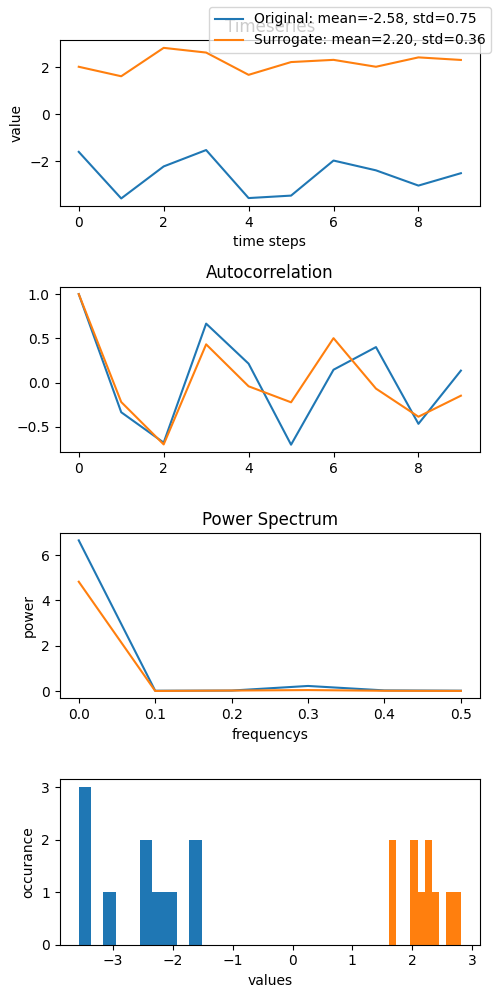

In [12]:
def FS_phase(timeseries):
    ft = np.fft.fft(timeseries)
    phase = np.angle(ft) #phase of the complex fourier values
    # print(np.imag(ft))
    amp = np.abs(ft) # amplitudes of the complex fourier values
    # print(amp)

    n = len(ft)
    print(n)
    # constrained that phi(f) = -phi(-f) that ifft is real
    if n % 2 == 0:
        half_phase = np.random.uniform(0,2*np.pi, n//2)
        phase = np.append(half_phase, -np.flip(half_phase))
    else:
        half_phase = np.random.uniform(0,2*np.pi, n//2+1)
        phase = np.append(0, np.append(half_phase[:-1], np.append([half_phase[-1]], -np.flip(half_phase[:-1]))))

    # amp
    # amp = np.append(0,amp)
    value = np.fft.ifft( amp* np.exp(phase*1j))
    # print(value)
    return np.real(value) # todo img actually not zero

plot_surrogates(ar2_data, FS_phase)

### AAFT

Null Hypothesis:
underlaying time series $\{y_i\}$ consistent with the null hypothesis of linear gaussian noise. The observed time series $\{x_i\}$ is given by $x_i = h(y_i)$. Monotonic nonlinear transformation of a linear gaussian process.

- rescale values to be gaussian
- apply FT (same Fourier spectrum)
- rescale back to have same amplitude distribution

[-1.59766316 -3.57441282 -2.21568108 -1.52061677 -3.55852294 -3.4542284
 -1.96658504 -2.382061   -3.02887511 -2.50345635]
[1 4 5 8 9 7 2 6 0 3]
[ 0.63111588  0.35843592 -0.92164715  0.2464214  -1.99293767 -1.15836806
 -0.92548905 -1.50467019 -0.97270505 -0.72551752]


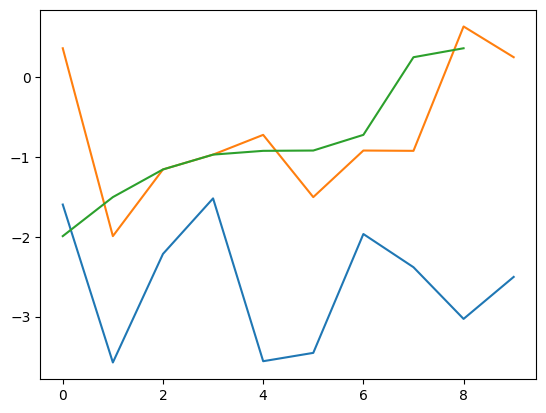

In [13]:
def AAFT(timeseries):
    n = len(timeseries)
    print(timeseries)
    indices_timeseries = np.argsort(timeseries)
    print(indices)
   


    # print(timeseries)
    y = np.random.normal(0,1,n)
    indices_y = np.argsort(y)
    
    print(y)
    # plt.plot(y)
    
    plt.plot(timeseries)
    y = y[indices]
    plt.plot(y)
    # plt.hist(y)
    # print(y[indices])

    sorted_timeseries = np.sort(timeseries)

    y = y[np.argsort(y)[:-1]] 
    # print(y)
    plt.plot(y)
    # print(y)

AAFT(ar2_data)

### IAAFT

Share distribution and power spectrum

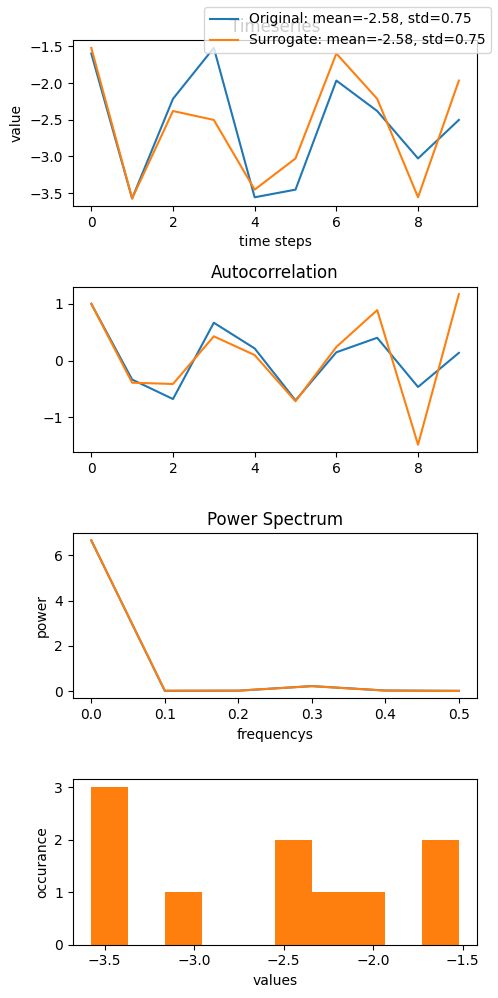

In [14]:
def IAAFT(timeseries):
    IAAFT_surr, msg = tiseanio('/home/luca/bin/surrogates', silent=True, data=timeseries)
    # print(IAAFT_surr)
    return IAAFT_surr

plot_surrogates(ar2_data, IAAFT)

chaos requires nonlinearity

## Testing for nonlinearity

**Null Hypothesis:** data arise from a linear stochastic process

\begin{gather}
A(1) = \frac{1}{n-1} \sum_{i=0}^{n}(x(i)-\overline{x})\frac{(x(i+1)-\overline{x})}{\overline{(x-\overline{x})^2}} \quad \text{with} \quad \overline{(x-\overline{x})^2} = \sqrt{\frac{1}{n}\sum_{i=0}^n (x(i)-\overline{x})^2}
\end{gather}
$ 

In [27]:
henon, msg = tiseano('/home/luca/bin/henon', '-l512', silent=True)

def A1(x):
    n = x.shape[0]
    # print(n)
    mu = x.mean()
    denominator = 0 
    for i in range(n):
        denominator += (x[i]-mu)**2
    denominator/n

    result = 0
    for i in range(n):
        result += (x[i]-mu)*(x[(i+1)%n]-mu)/denominator

    # print(f"res = {result}")
    return result/(n-1)

def T(x):
    n = x.shape[0]
    numerator = 0
    denominator = 0
    for i in range(n):
        numerator += (x[(i+1)%n]-x[i])**3 
        denominator += (x[(i+1)%n]-x[i]**2)
    numerator/=n
    denominator/=n 
    print(numerator)
    print(denominator)
    result = numerator / (denominator)**(3/2) + 20*A1(x)
    print(f"res = {result}")
    return result

print(T(henon[:,0]))

# print(henon[:,0])

-1.1469220681040169
-0.34343452956141485
res = 3.3273764979724114
3.3273764979724114
